# Regression Model for [PROJECT NAME] Using TensorFlow Decision Forests version 1
### David Lowe
### November 23, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The [PROJECT NAME] dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: [Sample Paragraph: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have been hosting playground-style competitions on Kaggle with fun but less complex, tabular datasets. These competitions will be great for people looking for something between the Titanic Getting Started competition and a Featured competition.]

ANALYSIS: [Sample Paragraph: The performance of the preliminary Gradient Boosted Trees model achieved an RMSE benchmark of 0.7013 on the validation dataset. The final model processed the validation dataset with a final RMSE score of 0.7006. When we applied the finalized model to Kaggle's test dataset, the model achieved an RMSE score of 0.7031.]

CONCLUSION: In this iteration, the TensorFlow Decision Forests model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: [PROJECT NAME] Dataset

Dataset ML Model: Regression with [numerical | categorical] attributes

Dataset Reference: [Sample URL: https://www.kaggle.com/c/tabular-playground-series-jan-2021]

One potential source of performance benchmarks: [Sample URL: https://www.kaggle.com/c/tabular-playground-series-jan-2021/leaderboard]

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Train and Evaluate Models
4. Fine-tune and Improve Models
5. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Installing TFDF might be necessary when using the script with Google Colab
# !pip install tensorflow_decision_forests

In [3]:
# For managing screen output when using the script with Google Colab
# !pip install wurlitzer

In [4]:
# # Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [5]:
# # Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [6]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [7]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [8]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from sklearn import metrics
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
# from tensorflow import keras
import tensorflow_decision_forests as tfdf

2021-11-23 22:47:13.886645: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-23 22:47:13.886706: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
# For managing screen output and model plotting when using the script with Google Colab

# try:
#   from wurlitzer import sys_pipes
# except:
#   from colabtools.googlelog import CaptureLog as sys_pipes

# from IPython.core.magic import register_line_magic
# from IPython.display import Javascript

### 1.b) Set up the controlling parameters and functions

In [10]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'mean_squared_error'
DEFAULT_METRICS = [tf.keras.metrics.RootMeanSquaredError(name='rmse')]

# Define the directory locations and file names
TRAIN_DATASET = 'train.csv'
TEST_DATASET = 'test.csv'

# # Check the number of GPUs accessible through TensorFlow
# print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow version: 2.7.0
Found TensorFlow Decision Forests v0.2.1


2021-11-23 22:47:16.041309: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-23 22:47:16.041358: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-23 22:47:16.041396: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (20d838f3f8d1): /proc/driver/nvidia/version does not exist


In [11]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [12]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [13]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [14]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jan/train.csv

--2021-11-23 22:47:16--  https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jan/train.csv
Resolving dainesanalytics.com (dainesanalytics.com)... 13.225.142.25, 13.225.142.69, 13.225.142.94, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.225.142.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87516226 (83M) [text/csv]
Saving to: ‘train.csv’

train.csv           100%[===================>]  83.46M  4.35MB/s    in 20s     

2021-11-23 22:47:36 (4.23 MB/s) - ‘train.csv’ saved [87516226/87516226]



In [15]:
df_dataset_import = pd.read_csv(TRAIN_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id     cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
0   1  0.670390  0.811300  0.643968  0.291791  0.284117  0.855953  0.890700   
1   3  0.388053  0.621104  0.686102  0.501149  0.643790  0.449805  0.510824   
2   4  0.834950  0.227436  0.301584  0.293408  0.606839  0.829175  0.506143   
3   5  0.820708  0.160155  0.546887  0.726104  0.282444  0.785108  0.752758   
4   8  0.935278  0.421235  0.303801  0.880214  0.665610  0.830131  0.487113   

      cont8     cont9    cont10    cont11    cont12    cont13    cont14  \
0  0.285542  0.558245  0.779418  0.921832  0.866772  0.878733  0.305411   
1  0.580748  0.418335  0.432632  0.439872  0.434971  0.369957  0.369484   
2  0.558771  0.587603  0.823312  0.567007  0.677708  0.882938  0.303047   
3  0.823267  0.574466  0.580843  0.769594  0.818143  0.914281  0.279528   
4  0.604157  0.874658  0.863427  0.983575  0.900464  0.935918  0.435772   

     target  
0  7.243043  
1  8.203331  
2  7.776091  
3  6.957716  
4  7

In [16]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cont1   300000 non-null  float64
 2   cont2   300000 non-null  float64
 3   cont3   300000 non-null  float64
 4   cont4   300000 non-null  float64
 5   cont5   300000 non-null  float64
 6   cont6   300000 non-null  float64
 7   cont7   300000 non-null  float64
 8   cont8   300000 non-null  float64
 9   cont9   300000 non-null  float64
 10  cont10  300000 non-null  float64
 11  cont11  300000 non-null  float64
 12  cont12  300000 non-null  float64
 13  cont13  300000 non-null  float64
 14  cont14  300000 non-null  float64
 15  target  300000 non-null  float64
dtypes: float64(15), int64(1)
memory usage: 36.6 MB


In [17]:
print(df_dataset_import.describe())

                  id          cont1          cont2          cont3  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean   249825.145857       0.506873       0.497898       0.521557   
std    144476.732562       0.203976       0.228159       0.200770   
min         1.000000      -0.082263      -0.031397       0.020967   
25%    124656.500000       0.343078       0.319170       0.344096   
50%    249738.500000       0.484005       0.553209       0.551471   
75%    374836.250000       0.643789       0.731263       0.648315   
max    499999.000000       1.016227       0.859697       1.006955   

               cont4          cont5          cont6          cont7  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean        0.515683       0.502022       0.526515       0.487890   
std         0.233035       0.220701       0.217909       0.181096   
min         0.152761       0.276377       0.066166      -0.097666   
25%         0.294935       0.2841

In [18]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id        0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
cont14    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [19]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

      cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
0  0.670390  0.811300  0.643968  0.291791  0.284117  0.855953  0.890700   
1  0.388053  0.621104  0.686102  0.501149  0.643790  0.449805  0.510824   
2  0.834950  0.227436  0.301584  0.293408  0.606839  0.829175  0.506143   
3  0.820708  0.160155  0.546887  0.726104  0.282444  0.785108  0.752758   
4  0.935278  0.421235  0.303801  0.880214  0.665610  0.830131  0.487113   

      cont8     cont9    cont10    cont11    cont12    cont13    cont14  \
0  0.285542  0.558245  0.779418  0.921832  0.866772  0.878733  0.305411   
1  0.580748  0.418335  0.432632  0.439872  0.434971  0.369957  0.369484   
2  0.558771  0.587603  0.823312  0.567007  0.677708  0.882938  0.303047   
3  0.823267  0.574466  0.580843  0.769594  0.818143  0.914281  0.279528   
4  0.604157  0.874658  0.863427  0.983575  0.900464  0.935918  0.435772   

     target  
0  7.243043  
1  8.203331  
2  7.776091  
3  6.957716  
4  7.951046  


In [20]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cont1   300000 non-null  float64
 1   cont2   300000 non-null  float64
 2   cont3   300000 non-null  float64
 3   cont4   300000 non-null  float64
 4   cont5   300000 non-null  float64
 5   cont6   300000 non-null  float64
 6   cont7   300000 non-null  float64
 7   cont8   300000 non-null  float64
 8   cont9   300000 non-null  float64
 9   cont10  300000 non-null  float64
 10  cont11  300000 non-null  float64
 11  cont12  300000 non-null  float64
 12  cont13  300000 non-null  float64
 13  cont14  300000 non-null  float64
 14  target  300000 non-null  float64
dtypes: float64(15)
memory usage: 34.3 MB


In [21]:
print(df_dataset_import.describe())

               cont1          cont2          cont3          cont4  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean        0.506873       0.497898       0.521557       0.515683   
std         0.203976       0.228159       0.200770       0.233035   
min        -0.082263      -0.031397       0.020967       0.152761   
25%         0.343078       0.319170       0.344096       0.294935   
50%         0.484005       0.553209       0.551471       0.482880   
75%         0.643789       0.731263       0.648315       0.748705   
max         1.016227       0.859697       1.006955       1.010402   

               cont5          cont6          cont7          cont8  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean        0.502022       0.526515       0.487890       0.525163   
std         0.220701       0.217909       0.181096       0.216221   
min         0.276377       0.066166      -0.097666       0.217260   
25%         0.284108       0.3561

In [22]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
cont14    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [23]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (300000, 15) df_features_train.shape: (300000, 14) df_target_train.shape: (300000,)


### 1.f) Set up the parameters for data visualization

In [24]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [25]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [26]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

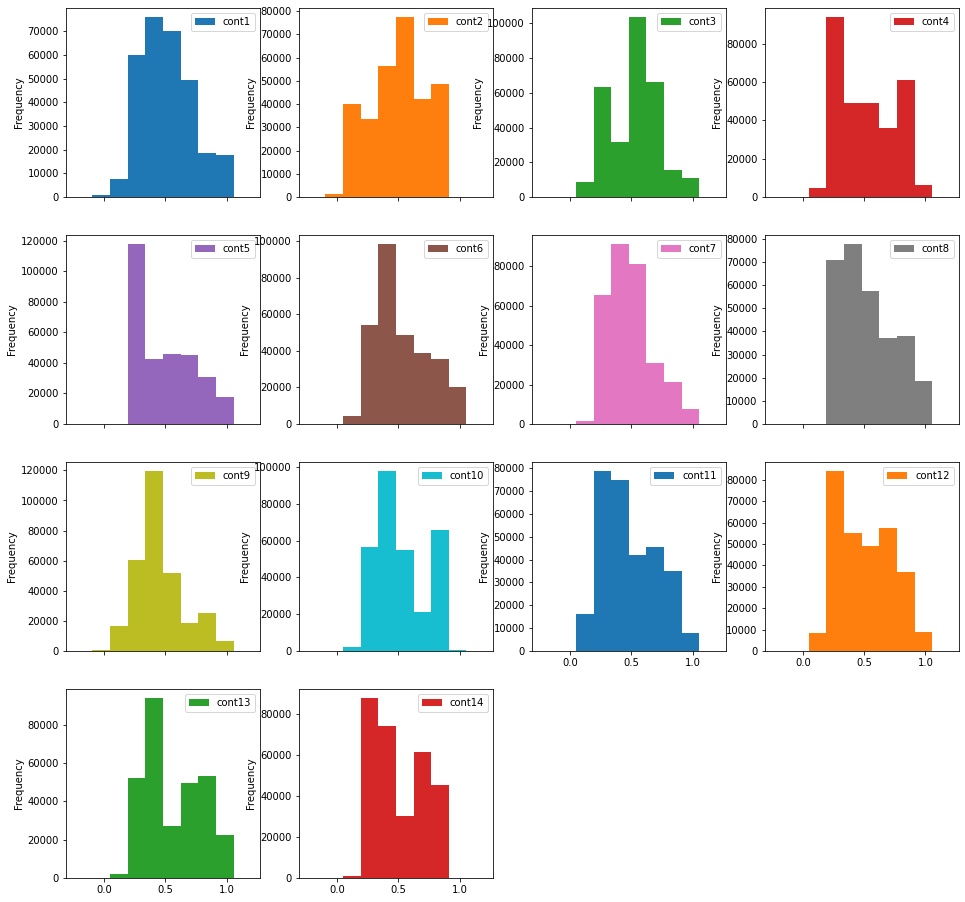

In [27]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

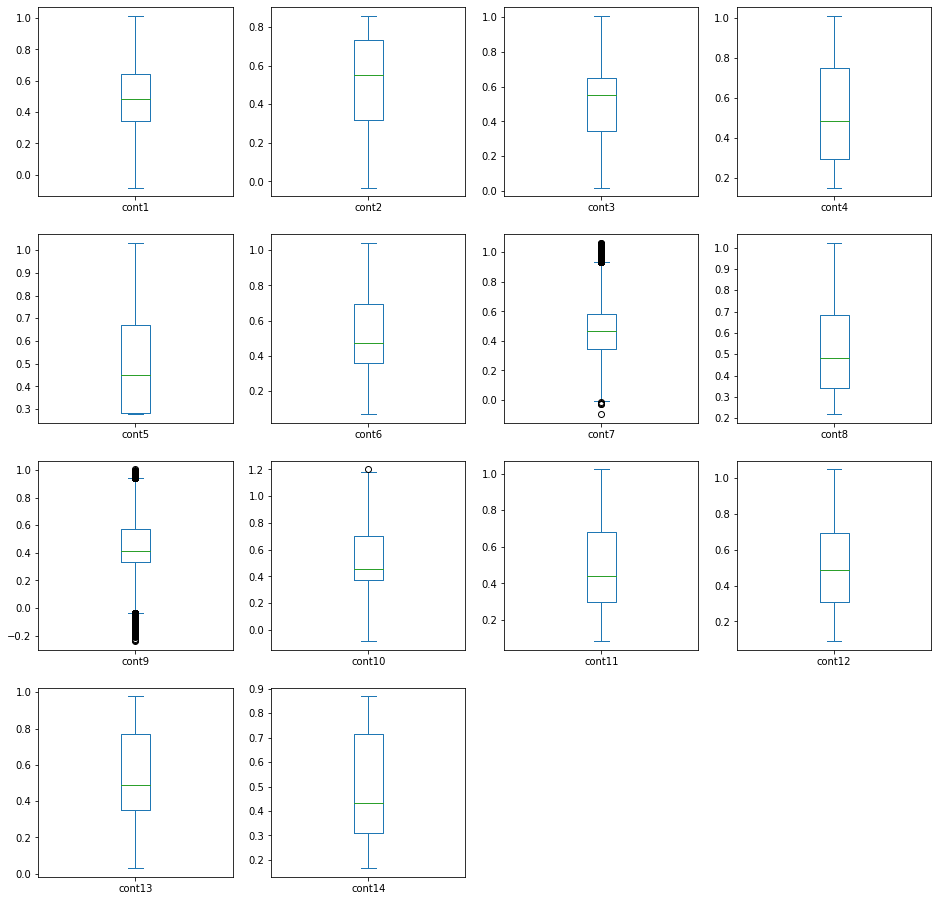

In [28]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

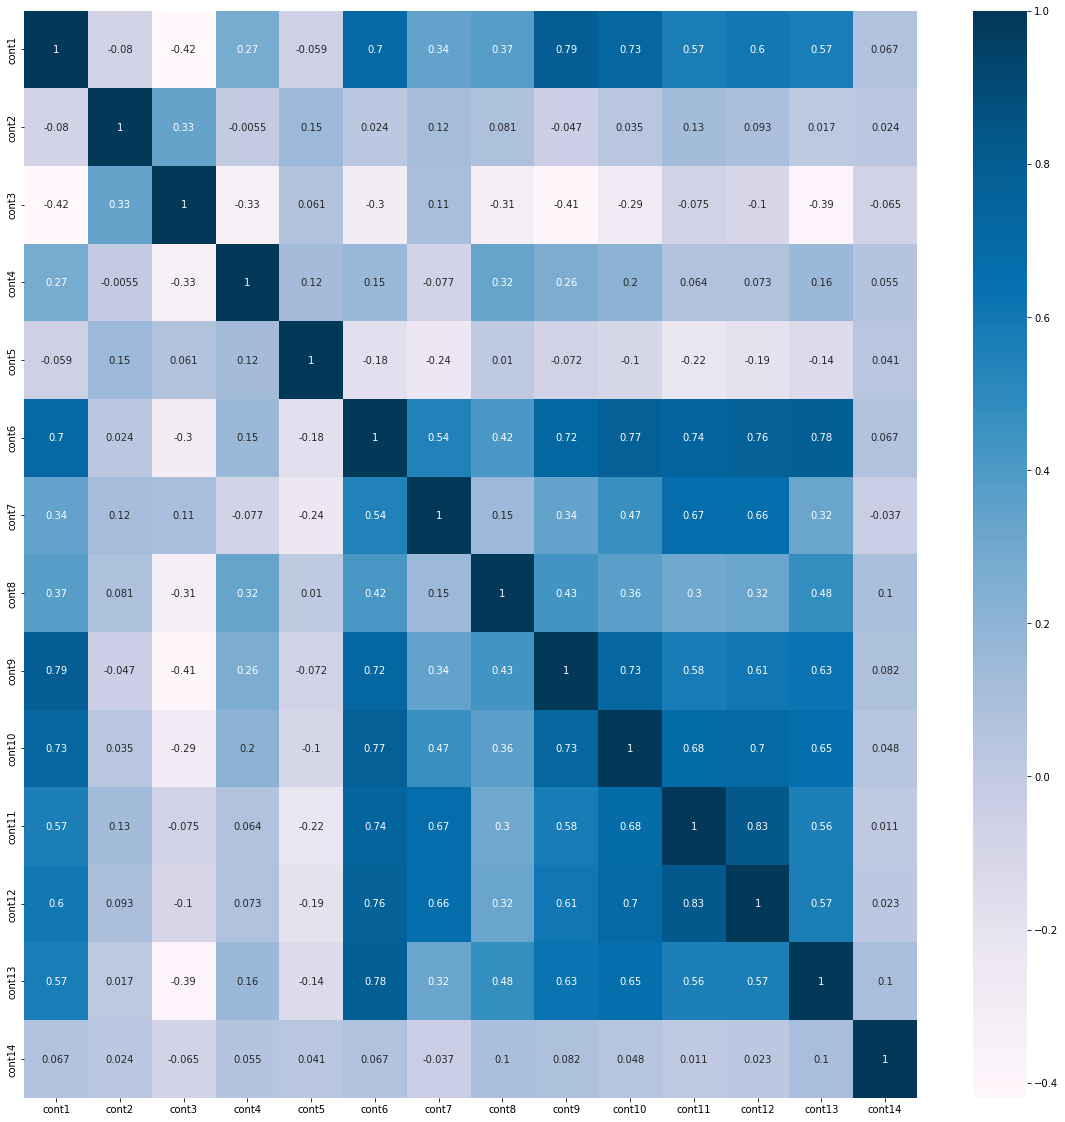

In [29]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [30]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [31]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Validation Sets

In [32]:
# Split the data further into training and validation datasets
df_dataset_train, df_dataset_valid = train_test_split(df_dataset_import, test_size=VAL_SET_RATIO, random_state=RNG_SEED)
print("df_dataset_train.shape: {} df_dataset_valid.shape: {}".format(df_dataset_train.shape, df_dataset_valid.shape))

df_dataset_train.shape: (240000, 15) df_dataset_valid.shape: (60000, 15)


In [33]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_train, label='target', task = tfdf.keras.Task.REGRESSION)
tfds_valid = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_valid, label='target', task = tfdf.keras.Task.REGRESSION)

/home/pythonml/appdev/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1612: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


### 3.b) Train and Evaluate the Random Forest Model

In [34]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
RF_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
RF_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     RF_model.fit(x=tfds_train)

# Train the model.
RF_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

3735/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 15

Number of columns by type:
	NUMERICAL: 15 (100%)

Columns:

NUMERICAL: 15 (100%)
	0: "cont1" NUMERICAL mean:0.506927 min:-0.0772377 max:1.01623 sd:0.204115
	1: "cont10" NUMERICAL mean:0.520411 min:-0.085046 max:1.19995 sd:0.201994
	2: "cont11" NUMERICAL mean:0.483942 min:0.0832767 max:1.02262 sd:0.22019
	3: "cont12" NUMERICAL mean:0.506728 min:0.091488 max:1.04903 sd:0.218957
	4: "cont13" NUMERICAL mean:0.55341 min:0.0353633 max:0.977845 sd:0.229728
	5: "cont14" NUMERICAL mean:0.503661 min:0.166367 max:0.868506 sd:0.208206
	6: "cont2" NUMERICAL mean:0.497598 min:-0.0313975 max:0.859697 sd:0.22809
	7: "cont3" NUMERICAL mean:0.521296 min:0.0209669 max:1.00695 sd:0.200616
	8: "cont4" NUMERICAL mean:0.515783 min:0.154548 ma

3750/3750 [==============================] - 173s 45ms/step
Model training time: 0:02:56.270956 



In [35]:
RF_eval = RF_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in RF_eval.items():
    print(f"{name}: {value:.4f}")

938/938 [==============================] - 8s 8ms/step - loss: 0.0000e+00 - rmse: 0.7047

loss: 0.0000
rmse: 0.7047


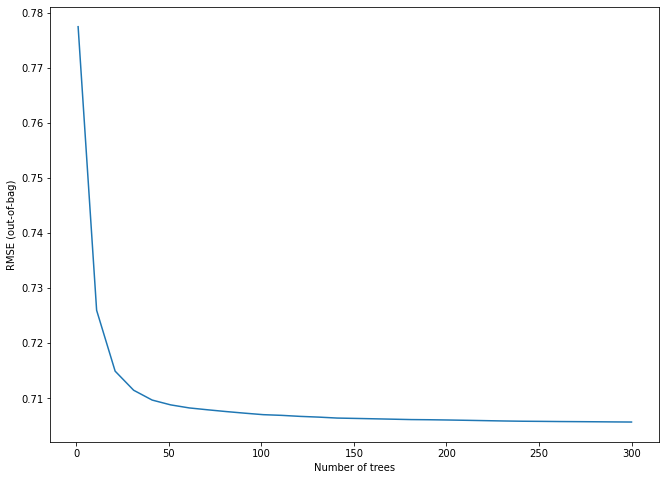

In [36]:
logs = RF_model.make_inspector().training_logs()

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [37]:
# Plot the model using Google Colab
# tfdf.model_plotter.plot_model_in_colab(RF_model)

### 3.c) Train and Evaluate the Decision Trees Model

In [38]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
CART_model = tfdf.keras.CartModel(task = tfdf.keras.Task.REGRESSION)
CART_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     CART_model.fit(x=tfds_train)

# Train the model.
CART_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

3734/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 15

Number of columns by type:
	NUMERICAL: 15 (100%)

Columns:

NUMERICAL: 15 (100%)
	0: "cont1" NUMERICAL mean:0.506927 min:-0.0772377 max:1.01623 sd:0.204115
	1: "cont10" NUMERICAL mean:0.520411 min:-0.085046 max:1.19995 sd:0.201994
	2: "cont11" NUMERICAL mean:0.483942 min:0.0832767 max:1.02262 sd:0.22019
	3: "cont12" NUMERICAL mean:0.506728 min:0.091488 max:1.04903 sd:0.218957
	4: "cont13" NUMERICAL mean:0.55341 min:0.0353633 max:0.977845 sd:0.229728
	5: "cont14" NUMERICAL mean:0.503661 min:0.166367 max:0.868506 sd:0.208206
	6: "cont2" NUMERICAL mean:0.497598 min:-0.0313975 max:0.859697 sd:0.22809
	7: "cont3" NUMERICAL mean:0.521296 min:0.0209669 max:1.00695 sd:0.200616
	8: "cont4" NUMERICAL mean:0.515783 min:0.154548 ma

3750/3750 [==============================] - 13s 3ms/step
Model training time: 0:00:12.752807 



[INFO cart.cc:375] 10311 nodes before pruning. 1 nodes after pruning.
[INFO kernel.cc:828] Export model in log directory: /tmp/tmp_3xwa5ly
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[WARNING utils.cc:73] The model does not have any input features i.e. the model is constant and will always return the same prediction.
[INFO decision_forest.cc:590] Model loaded with 1 root(s), 1 node(s), and 0 input feature(s).
[INFO abstract_model.cc:993] Engine "RandomForestOptPred" built
[INFO kernel.cc:848] Use fast generic engine


In [39]:
CART_eval = CART_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in CART_eval.items():
    print(f"{name}: {value:.4f}")

938/938 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - rmse: 5.6343

loss: 0.0000
rmse: 5.6343


In [40]:
# Plot the model using Google Colab
# tfdf.model_plotter.plot_model_in_colab(CART_model)

### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [41]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
GBT_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)
GBT_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     GBT_model.fit(x=tfds_train)

# Train the model.
GBT_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

3750/3750 [==============================] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 15

Number of columns by type:
	NUMERICAL: 15 (100%)

Columns:

NUMERICAL: 15 (100%)
	0: "cont1" NUMERICAL mean:0.506927 min:-0.0772377 max:1.01623 sd:0.204115
	1: "cont10" NUMERICAL mean:0.520411 min:-0.085046 max:1.19995 sd:0.201994
	2: "cont11" NUMERICAL mean:0.483942 min:0.0832767 max:1.02262 sd:0.22019
	3: "cont12" NUMERICAL mean:0.506728 min:0.091488 max:1.04903 sd:0.218957
	4: "cont13" NUMERICAL mean:0.55341 min:0.0353633 max:0.977845 sd:0.229728
	5: "cont14" NUMERICAL mean:0.503661 min:0.166367 max:0.868506 sd:0.208206
	6: "cont2" NUMERICAL mean:0.497598 min:-0.0313975 max:0.859697 sd:0.22809
	7: "cont3" NUMERICAL mean:0.521296 min:0.0209669 max:1.00695 sd:0.200616
	8: "cont4" NUMERICAL mean:0.515783 min:0.154548 ma

3750/3750 [==============================] - 130s 35ms/step


[INFO gradient_boosted_trees.cc:1426] 	num-trees:300 train-loss:0.683936 train-rmse:0.683936 valid-loss:0.698605 valid-rmse:0.698605
[INFO gradient_boosted_trees.cc:229] Truncates the model to 299 tree(s) i.e. 299  iteration(s).
[INFO gradient_boosted_trees.cc:263] Final model num-trees:299 valid-loss:0.698598 valid-rmse:0.698598
[INFO kernel.cc:828] Export model in log directory: /tmp/tmp2p0eknor
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO abstract_model.cc:993] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:848] Use fast generic engine


Model training time: 0:02:10.158251 



In [43]:
GBT_eval = GBT_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in GBT_eval.items():
    print(f"{name}: {value:.4f}")

938/938 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - rmse: 0.7013

loss: 0.0000
rmse: 0.7013


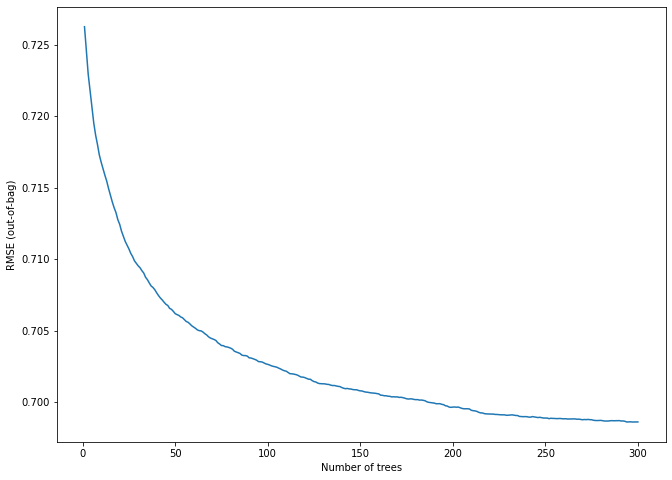

In [44]:
logs = GBT_model.make_inspector().training_logs()

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [45]:
# Plot the model using Google Colab
# tfdf.model_plotter.plot_model_in_colab(GBT_model)

In [46]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [47]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [48]:
for num_trees in [300, 500, 750, 1000]:
    # Define the baseline model for benchmarking
    start_time_module = datetime.now()
    reset_random()
    Tuning_model = tfdf.keras.GradientBoostedTreesModel(num_trees=num_trees, task = tfdf.keras.Task.REGRESSION)

    # Optionally, add evaluation metrics.
    Tuning_model.compile(metrics=DEFAULT_METRICS)

    # Train the model.
    Tuning_model.fit(x=tfds_train)

    Tuning_eval = Tuning_model.evaluate(tfds_valid, return_dict=True)
    print()

    for name, value in Tuning_eval.items():
        print(f"{name}: {value:.4f}")
    print ('Model optimization time:', (datetime.now() - start_time_module), '\n')

3739/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 15

Number of columns by type:
	NUMERICAL: 15 (100%)

Columns:

NUMERICAL: 15 (100%)
	0: "cont1" NUMERICAL mean:0.506927 min:-0.0772377 max:1.01623 sd:0.204115
	1: "cont10" NUMERICAL mean:0.520411 min:-0.085046 max:1.19995 sd:0.201994
	2: "cont11" NUMERICAL mean:0.483942 min:0.0832767 max:1.02262 sd:0.22019
	3: "cont12" NUMERICAL mean:0.506728 min:0.091488 max:1.04903 sd:0.218957
	4: "cont13" NUMERICAL mean:0.55341 min:0.0353633 max:0.977845 sd:0.229728
	5: "cont14" NUMERICAL mean:0.503661 min:0.166367 max:0.868506 sd:0.208206
	6: "cont2" NUMERICAL mean:0.497598 min:-0.0313975 max:0.859697 sd:0.22809
	7: "cont3" NUMERICAL mean:0.521296 min:0.0209669 max:1.00695 sd:0.200616
	8: "cont4" NUMERICAL mean:0.515783 min:0.154548 ma

3750/3750 [==============================] - 131s 35ms/step


[INFO gradient_boosted_trees.cc:1426] 	num-trees:300 train-loss:0.683936 train-rmse:0.683936 valid-loss:0.698605 valid-rmse:0.698605
[INFO gradient_boosted_trees.cc:229] Truncates the model to 299 tree(s) i.e. 299  iteration(s).
[INFO gradient_boosted_trees.cc:263] Final model num-trees:299 valid-loss:0.698598 valid-rmse:0.698598
[INFO kernel.cc:828] Export model in log directory: /tmp/tmpmf0sinnj
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO abstract_model.cc:993] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:848] Use fast generic engine


938/938 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - rmse: 0.7013

loss: 0.0000
rmse: 0.7013
Model optimization time: 0:02:16.771603 

3741/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 15

Number of columns by type:
	NUMERICAL: 15 (100%)

Columns:

NUMERICAL: 15 (100%)
	0: "cont1" NUMERICAL mean:0.506927 min:-0.0772377 max:1.01623 sd:0.204115
	1: "cont10" NUMERICAL mean:0.520411 min:-0.085046 max:1.19995 sd:0.201994
	2: "cont11" NUMERICAL mean:0.483942 min:0.0832767 max:1.02262 sd:0.22019
	3: "cont12" NUMERICAL mean:0.506728 min:0.091488 max:1.04903 sd:0.218957
	4: "cont13" NUMERICAL mean:0.55341 min:0.0353633 max:0.977845 sd:0.229728
	5: "cont14" NUMERICAL mean:0.503661 min:0.166367 max:0.868506 sd:0.208206
	6: "cont2" NUMERICAL mean:0.497598 min:-0.0313975 max:0.859697 sd:0.22809
	7: "cont3" NUMERICAL mean:0.521296 min:0.0209669 max:1.00695 sd:0.200616
	8: "cont4" NUMERICAL mean:0.515783 min:0.154548 ma

3750/3750 [==============================] - 185s 49ms/step


[INFO gradient_boosted_trees.cc:2740] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.697896
[INFO gradient_boosted_trees.cc:229] Truncates the model to 404 tree(s) i.e. 404  iteration(s).
[INFO gradient_boosted_trees.cc:263] Final model num-trees:404 valid-loss:0.697896 valid-rmse:0.697896
[INFO kernel.cc:828] Export model in log directory: /tmp/tmp34_dd_p1
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO abstract_model.cc:993] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:848] Use fast generic engine


938/938 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - rmse: 0.7011

loss: 0.0000
rmse: 0.7011
Model optimization time: 0:03:10.095789 

3749/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 15

Number of columns by type:
	NUMERICAL: 15 (100%)

Columns:

NUMERICAL: 15 (100%)
	0: "cont1" NUMERICAL mean:0.506927 min:-0.0772377 max:1.01623 sd:0.204115
	1: "cont10" NUMERICAL mean:0.520411 min:-0.085046 max:1.19995 sd:0.201994
	2: "cont11" NUMERICAL mean:0.483942 min:0.0832767 max:1.02262 sd:0.22019
	3: "cont12" NUMERICAL mean:0.506728 min:0.091488 max:1.04903 sd:0.218957
	4: "cont13" NUMERICAL mean:0.55341 min:0.0353633 max:0.977845 sd:0.229728
	5: "cont14" NUMERICAL mean:0.503661 min:0.166367 max:0.868506 sd:0.208206
	6: "cont2" NUMERICAL mean:0.497598 min:-0.0313975 max:0.859697 sd:0.22809
	7: "cont3" NUMERICAL mean:0.521296 min:0.0209669 max:1.00695 sd:0.200616
	8: "cont4" NUMERICAL mean:0.515783 min:0.154548 ma

3750/3750 [==============================] - 182s 49ms/step


[INFO gradient_boosted_trees.cc:2740] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.697896
[INFO gradient_boosted_trees.cc:229] Truncates the model to 404 tree(s) i.e. 404  iteration(s).
[INFO gradient_boosted_trees.cc:263] Final model num-trees:404 valid-loss:0.697896 valid-rmse:0.697896
[INFO kernel.cc:828] Export model in log directory: /tmp/tmpayr7_134
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO abstract_model.cc:993] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:848] Use fast generic engine


938/938 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - rmse: 0.7010

loss: 0.0000
rmse: 0.7010
Model optimization time: 0:03:05.377054 

3744/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 15

Number of columns by type:
	NUMERICAL: 15 (100%)

Columns:

NUMERICAL: 15 (100%)
	0: "cont1" NUMERICAL mean:0.506927 min:-0.0772377 max:1.01623 sd:0.204115
	1: "cont10" NUMERICAL mean:0.520411 min:-0.085046 max:1.19995 sd:0.201994
	2: "cont11" NUMERICAL mean:0.483942 min:0.0832767 max:1.02262 sd:0.22019
	3: "cont12" NUMERICAL mean:0.506728 min:0.091488 max:1.04903 sd:0.218957
	4: "cont13" NUMERICAL mean:0.55341 min:0.0353633 max:0.977845 sd:0.229728
	5: "cont14" NUMERICAL mean:0.503661 min:0.166367 max:0.868506 sd:0.208206
	6: "cont2" NUMERICAL mean:0.497598 min:-0.0313975 max:0.859697 sd:0.22809
	7: "cont3" NUMERICAL mean:0.521296 min:0.0209669 max:1.00695 sd:0.200616
	8: "cont4" NUMERICAL mean:0.515783 min:0.154548 ma

3750/3750 [==============================] - 183s 49ms/step


[INFO gradient_boosted_trees.cc:2740] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.697896
[INFO gradient_boosted_trees.cc:229] Truncates the model to 404 tree(s) i.e. 404  iteration(s).
[INFO gradient_boosted_trees.cc:263] Final model num-trees:404 valid-loss:0.697896 valid-rmse:0.697896
[INFO kernel.cc:828] Export model in log directory: /tmp/tmpdaw7avzo
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO abstract_model.cc:993] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:848] Use fast generic engine


938/938 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - rmse: 0.7009

loss: 0.0000
rmse: 0.7009
Model optimization time: 0:03:25.187235 



In [49]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [50]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [51]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
Final_model = tfdf.keras.GradientBoostedTreesModel(num_trees=1000, task = tfdf.keras.Task.REGRESSION)

# Optionally, add evaluation metrics.
Final_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     Final_model.fit(x=tfds_train)

# Train the model.
Final_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

3746/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 15

Number of columns by type:
	NUMERICAL: 15 (100%)

Columns:

NUMERICAL: 15 (100%)
	0: "cont1" NUMERICAL mean:0.506927 min:-0.0772377 max:1.01623 sd:0.204115
	1: "cont10" NUMERICAL mean:0.520411 min:-0.085046 max:1.19995 sd:0.201994
	2: "cont11" NUMERICAL mean:0.483942 min:0.0832767 max:1.02262 sd:0.22019
	3: "cont12" NUMERICAL mean:0.506728 min:0.091488 max:1.04903 sd:0.218957
	4: "cont13" NUMERICAL mean:0.55341 min:0.0353633 max:0.977845 sd:0.229728
	5: "cont14" NUMERICAL mean:0.503661 min:0.166367 max:0.868506 sd:0.208206
	6: "cont2" NUMERICAL mean:0.497598 min:-0.0313975 max:0.859697 sd:0.22809
	7: "cont3" NUMERICAL mean:0.521296 min:0.0209669 max:1.00695 sd:0.200616
	8: "cont4" NUMERICAL mean:0.515783 min:0.154548 ma

3750/3750 [==============================] - 184s 49ms/step


[INFO gradient_boosted_trees.cc:2740] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.697896
[INFO gradient_boosted_trees.cc:229] Truncates the model to 404 tree(s) i.e. 404  iteration(s).
[INFO gradient_boosted_trees.cc:263] Final model num-trees:404 valid-loss:0.697896 valid-rmse:0.697896
[INFO kernel.cc:828] Export model in log directory: /tmp/tmp261duh9d
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO abstract_model.cc:993] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:848] Use fast generic engine


Model training time: 0:03:22.297653 



In [52]:
Final_model.summary()

Model: "gradient_boosted_trees_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (14):
	cont1
	cont10
	cont11
	cont12
	cont13
	cont14
	cont2
	cont3
	cont4
	cont5
	cont6
	cont7
	cont8
	cont9

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1. "__LABEL"  4.884836 ################
    2.   "cont1"  4.142121 ####
    3.   "cont8"  4.106256 ###
    4.   "cont7"  4.104021 ###
    5.  "cont11"  4.097224 ###
    6.   "cont2"  4.057401 ###
    7.   "cont9"  4.032707 ##
    8.   "cont5"  4.022533 ##
    9.  "cont14"  4.008258 ##
   10.  "cont13"  3.993547 ##
   11.  "cont12"  3.985177 ##
   12.   "cont6"  3.947373 #
   13.   "cont3"  3.943475 #
   14.  "cont10"  3.937312 #
   15.   "cont4"  3.85521

In [53]:
Final_eval = Final_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in Final_eval.items():
    print(f"{name}: {value:.4f}")

938/938 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - rmse: 0.7008

loss: 0.0000
rmse: 0.7008


In [54]:
# Plot the model using Google Colab
# tfdf.model_plotter.plot_model_in_colab(Final_model)

### 5.b) Load Test Dataset and Make Predictions

In [55]:
if not os.path.exists(TEST_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jan/test.csv

--2021-11-23 23:10:14--  https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jan/test.csv
Resolving dainesanalytics.com (dainesanalytics.com)... 13.225.142.96, 13.225.142.69, 13.225.142.94, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.225.142.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54761136 (52M) [text/csv]
Saving to: ‘test.csv’

test.csv            100%[===================>]  52.22M  3.87MB/s    in 15s     

2021-11-23 23:10:30 (3.37 MB/s) - ‘test.csv’ saved [54761136/54761136]



In [56]:
df_features_test = pd.read_csv(TEST_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

   id     cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
0   0  0.353600  0.738780  0.600939  0.293377  0.285691  0.458006  0.620704   
1   2  0.907222  0.189756  0.215531  0.869915  0.301333  0.528958  0.390351   
2   6  0.179287  0.355353  0.623972  0.437812  0.282476  0.320826  0.386789   
3   7  0.359385  0.181049  0.551368  0.206386  0.280763  0.482076  0.506677   
4  10  0.335791  0.682607  0.676481  0.219465  0.282861  0.581721  0.748639   

      cont8     cont9    cont10    cont11    cont12    cont13    cont14  
0  0.422249  0.369203  0.435727  0.550540  0.699134  0.286864  0.364515  
1  0.521112  0.794779  0.798580  0.446475  0.449037  0.916964  0.513002  
2  0.776422  0.222268  0.229102  0.211913  0.222651  0.327164  0.827941  
3  0.362793  0.379737  0.345686  0.445276  0.518485  0.299028  0.598166  
4  0.350158  0.448915  0.506878  0.817721  0.805895  0.790591  0.249275  


In [57]:
# # Finalize the test dataset for the prediction activities
# df_target_test = df_features_test['target']
# df_features_test = df_features_test.drop(['target'], axis=1)
# print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

In [58]:
# # Finalize the test dataset for the modeling testing
# array_features_test = preprocessor.transform(df_features_test)
# array_target_test = df_target_test.ravel()
# print("array_features_test.shape: {} array_target_test.shape: {}".format(array_features_test.shape, array_target_test.shape))

In [59]:
# test_predictions = test_model.predict(array_features_test)
# print('RMSE for the model is: ', math.sqrt(metrics.mean_squared_error(array_target_test, test_predictions)))
# print('R2 for the model is: ', metrics.r2_score(array_target_test, test_predictions))

In [60]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

   id
0   0
1   2
2   6
3   7
4  10


In [61]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

      cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
0  0.353600  0.738780  0.600939  0.293377  0.285691  0.458006  0.620704   
1  0.907222  0.189756  0.215531  0.869915  0.301333  0.528958  0.390351   
2  0.179287  0.355353  0.623972  0.437812  0.282476  0.320826  0.386789   
3  0.359385  0.181049  0.551368  0.206386  0.280763  0.482076  0.506677   
4  0.335791  0.682607  0.676481  0.219465  0.282861  0.581721  0.748639   

      cont8     cont9    cont10    cont11    cont12    cont13    cont14  
0  0.422249  0.369203  0.435727  0.550540  0.699134  0.286864  0.364515  
1  0.521112  0.794779  0.798580  0.446475  0.449037  0.916964  0.513002  
2  0.776422  0.222268  0.229102  0.211913  0.222651  0.327164  0.827941  
3  0.362793  0.379737  0.345686  0.445276  0.518485  0.299028  0.598166  
4  0.350158  0.448915  0.506878  0.817721  0.805895  0.790591  0.249275  


In [62]:
# Finalize the test dataset for the prediction activities
tfds_test = tfdf.keras.pd_dataframe_to_tf_dataset(df_features_test, task = tfdf.keras.Task.REGRESSION)

In [63]:
# Make batched predictions
test_predictions = Final_model.predict(tfds_test)
print(test_predictions)

[[7.9471517]
 [7.8515325]
 [7.91051  ]
 ...
 [7.9942436]
 [8.031649 ]
 [7.947554 ]]


In [64]:
df_kaggle_submission['target'] = test_predictions
print(df_kaggle_submission.head())

   id    target
0   0  7.947152
1   2  7.851532
2   6  7.910510
3   7  8.272182
4  10  8.282704


In [65]:
# # Create the submission file
# submission_file = df_kaggle_submission.to_csv(header=True, index=False)
# filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
# with open(filename, 'w') as f:
#     f.write(submission_file)
#     print('Completed writing output file: ' + filename)

In [66]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [67]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:23:25.866469
